Цель работы: отследить влияние условий жизни учащихся в возрасте от 15  до 22 лет на их успеваемость по математике, чтобы на ранней  стадии выявлять студентов, находящихся в группе риска.

## 1. Первичная обработка данных

In [26]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from itertools import combinations

from scipy.stats import ttest_ind

math = pd.read_csv('stud_math.csv')

display(math.head())

math.info()

math.shape

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,...,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,...,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,...,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,...,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,...,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

(395, 30)

In [27]:
def numeric_column_info(column, column_name='Data', bounds=()):
   
    """ Функция принимает столбец с числовым признаком, его имя 
        и предполагаемые границы изменения для отбора выбросов.
        Если границы не указаны, то отбор по IQR.
        Печатает статистические характеристики и 
        информацию о выбросах, а также рисует гистограмму распределения признака
    """
    if bounds == ():
        out_type = 'IQR'
    else:
        out_type = 'Bounds'
    
    values = column.count()
    null_values = column.isnull().sum()
    max_value = column.max()
    min_value = column.min()
    mean_value = round(column.mean(),1)
    std_value = round(column.std(),2)
    perc25 = column.quantile(0.25)
    perc50 = column.quantile(0.50)
    perc75 = column.quantile(0.75)
    IQR = column.quantile(0.75) - column.quantile(0.25)
    
    if out_type == 'IQR':
        left_bound = perc25 - 1.5*IQR
        right_bound = perc75 + 1.5*IQR
    elif out_type == 'Bounds':
        left_bound = bounds[0]
        right_bound = bounds[1]
    else:
        print('Unknown out_type')
    
    out_lower = column.loc[column<left_bound].value_counts().sum()
    out_upper = column.loc[column>right_bound].value_counts().sum()
    total_out = out_lower + out_upper
    print(f'Признак {column_name}:\n\nВсего записей: {values}\nПропущенных (null): {null_values}\n'
          f'Максимум: {max_value}\n75-й перцентиль: {perc75}\n50-й перцентиль: {perc50}\n25-й перцентиль: {perc25}\n'
          f'Минимум: {min_value}\nСреднее арифм.: {mean_value}\nСКО: {std_value}\n'
          f'IQR: {IQR}\nГраницы валидных данных: [{left_bound},{right_bound}]')
    
    column.loc[column.between(left_bound, right_bound)].hist(
                                                             bins = 40,
                                                             range = (min_value, max_value), 
                                                             label = column_name + ' valid')
    if total_out == 0:
        print('\033[1;32;43mВыбросов по ' + out_type + ' не обнаружено')
    else:
        print('\033[1;31;43mОбнаружены выбросы по ' + out_type)
        print(f'Выбросов: {total_out}\nСверху: {out_upper}\nСнизу: {out_lower}')
        column.loc[~column.between(left_bound, right_bound)].hist(
                                                             bins = 40,
                                                             range = (min_value, max_value), 
                                                             label = column_name + ' outlayers')
    plt.legend();

In [28]:
def nominative_column_info(column, column_name='Data', rotation=0):
    
    """ Функция принимает столбец с номинативными признаками, его имя 
        и параметр поворота подписи оси Х.
        Печатает информацию о количестве валидных записей и о пропущенных записях. 
        Рисует столбчатый график количества каждого признака.
    """
    print(f'Признак {column_name}:\n')
    
   
    null_values = column.isnull().sum()
    if null_values == 0:
        print(f'Пропущенные записи отсутствуют\n')
        print_nominative_stat(column)
        column.value_counts(dropna=True).plot(kind='bar',grid=True,
                                          colormap='coolwarm',title=column_name)
        plt.xticks(rotation=rotation)
    else:
        print(f'Присутствуют пропущенные записи\n')
        print(f'with NaN:')
        print_nominative_stat(column, False)
        print(f'drop NaN:')
        print_nominative_stat(column)
        
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
        column.value_counts(dropna=False).plot(ax=axes[1],kind='bar',grid=True,
                                           colormap='coolwarm',title=column_name+' (with NaN)')
    
        column.value_counts(dropna=True).plot(ax=axes[0],kind='bar',grid=True,
                                          colormap='coolwarm',title=column_name+' (drop NaN)')
        for ax in fig.axes:
            ax.tick_params(labelrotation=rotation)

In [29]:
def print_nominative_stat(column, dropna_value=True):
    
     """ Функция принимает столбец с номинативными признаками и
         признак подсчёта пропущенных значений. 
         Печатает информацию о количестве каждого признака в столбце, его процентное
         содержание и общее количество всех признаков.
     """
    
     norm = pd.DataFrame(column.value_counts(dropna=dropna_value, normalize = True))
     unnorm = pd.DataFrame(column.value_counts(dropna=dropna_value))
     unnorm.columns=['number']
     unnorm.loc[:,'percent']=round(norm[norm.columns[0]]*100,1)
     unnorm.loc['Total:'] = unnorm[['number','percent']].sum()
     print(unnorm,'\n')

Признак Studytime, granular:

Присутствуют пропущенные записи

with NaN:
        number  percent
-6.0     194.0     49.1
-3.0     103.0     26.1
-9.0      64.0     16.2
-12.0     27.0      6.8
NaN        7.0      1.8
Total:   395.0    100.0 

drop NaN:
        number  percent
-6.0     194.0     50.0
-3.0     103.0     26.5
-9.0      64.0     16.5
-12.0     27.0      7.0
Total:   388.0    100.0 



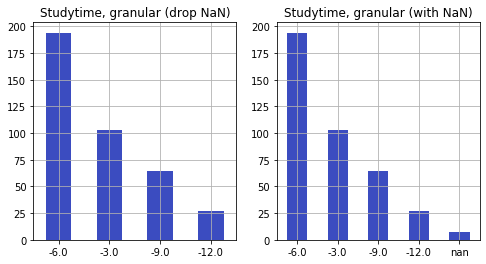

In [30]:
nominative_column_info(math['studytime, granular'], column_name='Studytime, granular', rotation=0)

Признак Studytime:

Присутствуют пропущенные записи

with NaN:
        number  percent
2.0      194.0     49.1
1.0      103.0     26.1
3.0       64.0     16.2
4.0       27.0      6.8
NaN        7.0      1.8
Total:   395.0    100.0 

drop NaN:
        number  percent
2.0      194.0     50.0
1.0      103.0     26.5
3.0       64.0     16.5
4.0       27.0      7.0
Total:   388.0    100.0 



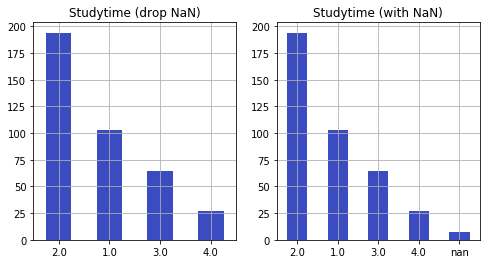

In [31]:
nominative_column_info(math['studytime'], column_name='Studytime', rotation=0)

In [32]:
math['studytime'].corr(math['studytime, granular'])

-1.0

In [33]:
math.drop(['studytime, granular'], inplace = True, axis =1)

После удаления неизвестного признака осталось 12 числовых и 17 нечисловых признаков. Перейдем к их рассмотрению.
1. Колонка [school] (номинативная переменная), содержит в себе аббревиатуру школы. 
Подавляющее большинство данных имеет значение GP (349 или 88.4%), остальная часть приходится на MS (46 или 11.6%). Пропущенные записи отсутствуют.

Признак School:

Пропущенные записи отсутствуют

        number  percent
GP       349.0     88.4
MS        46.0     11.6
Total:   395.0    100.0 



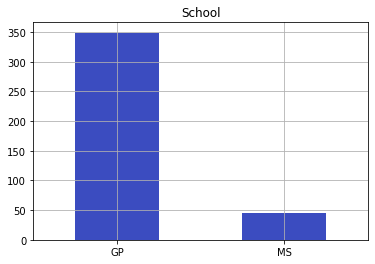

In [34]:
nominative_column_info(math.school, column_name='School', rotation=0)

2. Колонка [sex] (номинативная переменная), содержит в себе пол ученика. Возможные значения признака разделились почти поровну: F (девушки - 208 или 52.7%) и M (юноши - 187 или 47.3%). Такое разделение благоприятно для модели, так как нет сильного перекоса данных. Пропущенные записи отсутствуют.   

Признак Sex:

Пропущенные записи отсутствуют

        number  percent
F        208.0     52.7
M        187.0     47.3
Total:   395.0    100.0 



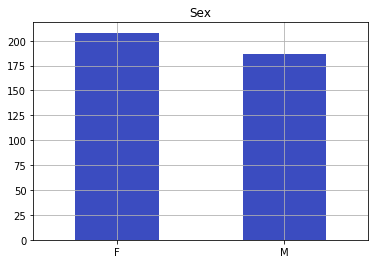

In [35]:
nominative_column_info(math.sex, column_name='Sex', rotation=0)

3. Колонка [age] (количественная переменная). Содержит в себе возраст ученика. Можно отметить, что значение 
признака варьируется в диапазоне [15,22], как и было заявлено в описании. Выбросов нет. Пропущенные записи отсутствуют. Медианный возраст (17 лет)
незначительно отличается от среднего (16.7 года), среднеквадратическое отклонение равно 1.28 года. 

Признак Age:

Всего записей: 395
Пропущенных (null): 0
Максимум: 22
75-й перцентиль: 18.0
50-й перцентиль: 17.0
25-й перцентиль: 16.0
Минимум: 15
Среднее арифм.: 16.7
СКО: 1.28
IQR: 2.0
Границы валидных данных: [15,22]
Выбросов по Bounds не обнаружено


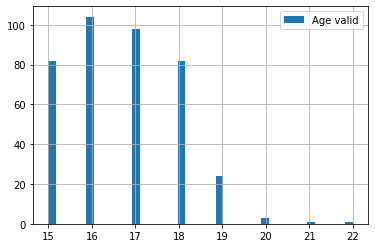

In [36]:
 numeric_column_info(math.age, 'Age', bounds=(15,22)) 

4. Колонка [address] (номинативная переменная), содержит в себе тип адреса ученика ('U' - городской, 'R' - за городом). Среди двух вариантов значений признака U (295 или 74.7%) и R (83 или 21%) присутствуют пропущенные записи в количестве 17 или 4.3%. Из гистограммы значений признака видно, что большинство учеников проживает в городе.

Признак Address:

Присутствуют пропущенные записи

with NaN:
        number  percent
U        295.0     74.7
R         83.0     21.0
NaN       17.0      4.3
Total:   395.0    100.0 

drop NaN:
        number  percent
U        295.0     78.0
R         83.0     22.0
Total:   378.0    100.0 



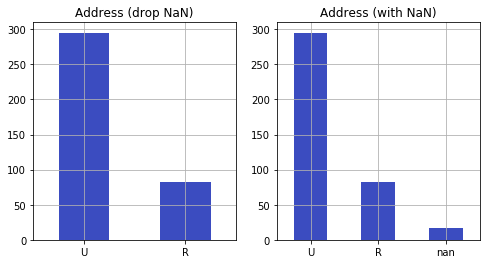

In [37]:
nominative_column_info(math.address, column_name='Address', rotation=0)

5. Колонка [famsize] (номинативная переменная), содержит в себе размер семьи ученика ('LE3' - не более трёх, 'GT3'- более трёх человек). Среди двух вариантов значений признака GT3 (261 или 66.1%) и LE3 (107 или 27.1%) присутствуют пропущенные записи  в количестве 27 или 6.8%. Из гистограммы значений признака видно, что большинство учеников проживает в семьях, размер которых больше 3 человек (примерное отношение 7:3). 

Признак Family_size:

Присутствуют пропущенные записи

with NaN:
        number  percent
GT3      261.0     66.1
LE3      107.0     27.1
NaN       27.0      6.8
Total:   395.0    100.0 

drop NaN:
        number  percent
GT3      261.0     70.9
LE3      107.0     29.1
Total:   368.0    100.0 



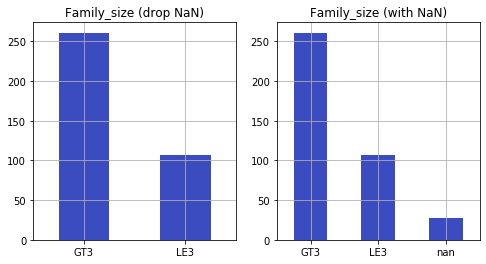

In [38]:
nominative_column_info(math.famsize, column_name='Family_size', rotation=0)

6.  Колонка [Pstatus] (номинативная переменная), содержит в себе статус совместного проживания родителей ('T' - живут вместе, 'A' - раздельно). Подавляющее большинство родителей учеников (314 или 79.5%) проживают вместе, количество пар, проживающих отдельно, равно 36 или 9.1%. Присутствут пропущенные записи в количестве 45 или 11%.  

Признак Parents_status:

Присутствуют пропущенные записи

with NaN:
        number  percent
T        314.0     79.5
NaN       45.0     11.4
A         36.0      9.1
Total:   395.0    100.0 

drop NaN:
        number  percent
T        314.0     89.7
A         36.0     10.3
Total:   350.0    100.0 



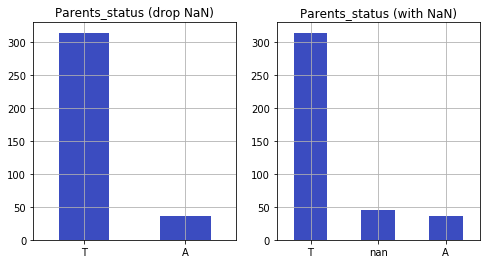

In [40]:
nominative_column_info(math.Pstatus, column_name='Parents_status', rotation=0)

7. Колонка [Medu] (ранговая переменная), содержит в себе признак образования матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее). Колонка содержит 3 или 0.8% пропущенных записей. Из гистограммы распределения следует, что большинство (131 или 33.2%) матерей имеет высшее образование. Примерно одинаковое количество матерей (25.8 и 24.6%) закончили 9 и 11 классов соответственно, 14.9% закончили начальную школу и менее одного процента матерей не имеет образования вовсе. 

Признак Mother_education:

Присутствуют пропущенные записи

with NaN:
        number  percent
4.0      131.0     33.2
2.0      102.0     25.8
3.0       97.0     24.6
1.0       59.0     14.9
0.0        3.0      0.8
NaN        3.0      0.8
Total:   395.0    100.1 

drop NaN:
        number  percent
4.0      131.0     33.4
2.0      102.0     26.0
3.0       97.0     24.7
1.0       59.0     15.1
0.0        3.0      0.8
Total:   392.0    100.0 



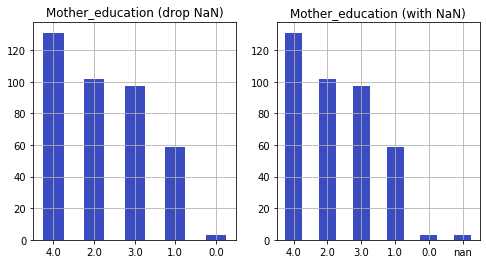

In [41]:
nominative_column_info(math.Medu, column_name='Mother_education', rotation=0)

8. Колонка [Fedu] (ранговая переменная), содержит в себе признак образования отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее). Можно заметить, что имеет место 1 выброс из заявленного в описании диапазона. 

Признак Father_education:

Присутствуют пропущенные записи

with NaN:
        number  percent
2.0      106.0     26.8
3.0       96.0     24.3
4.0       88.0     22.3
1.0       78.0     19.7
NaN       24.0      6.1
0.0        2.0      0.5
40.0       1.0      0.3
Total:   395.0    100.0 

drop NaN:
        number  percent
2.0      106.0     28.6
3.0       96.0     25.9
4.0       88.0     23.7
1.0       78.0     21.0
0.0        2.0      0.5
40.0       1.0      0.3
Total:   371.0    100.0 



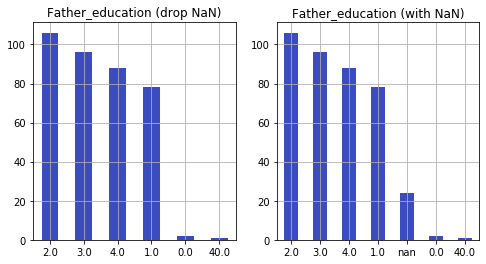

In [42]:
nominative_column_info(math.Fedu, column_name='Father_education', rotation=0)

Найдем выброс:

In [43]:
math.loc[math.Fedu>4]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
11,GP,F,15,U,GT3,NaN,2.0,40.0,services,other,...,yes,yes,yes,no,5.0,2.0,2.0,4.0,4.0,60.0


Скорее всего, была допущена ошибка (лишний ноль), уберем его, записав 4 вместо 40.

In [44]:
math.loc[11, 'Fedu'] = 4

Теперь взглянем на новое распределение признака еще раз. Отметим, что присутствуют пропущенные записи в количестве 24 или 6.1%. Из гистограммы распределения признака следует, что менее 1% отцов не имеет образования. 19.7% или 78 человек закончили лишь начальную школу. Остальные варианты признака распределены примерно поровну. 

Признак Father_education:

Присутствуют пропущенные записи

with NaN:
        number  percent
2.0      106.0     26.8
3.0       96.0     24.3
4.0       89.0     22.5
1.0       78.0     19.7
NaN       24.0      6.1
0.0        2.0      0.5
Total:   395.0     99.9 

drop NaN:
        number  percent
2.0      106.0     28.6
3.0       96.0     25.9
4.0       89.0     24.0
1.0       78.0     21.0
0.0        2.0      0.5
Total:   371.0    100.0 



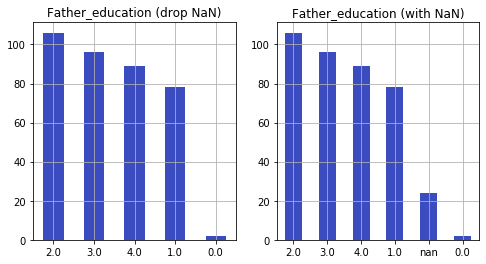

In [45]:
nominative_column_info(math.Fedu, column_name='Father_education', rotation=0)

9. Колонка [Mjob] (номинативная переменная), содержит в себе признак места работы матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос. служба, 'at_home' - не работает, 'other' - другое). Отметим, что здесь присутствуют пропущенные записи в количестве 19 или 4.8%. Из диаграммы распределния значений признака следует, что большинство матерей 133 или 33.7% не указали конкретное место работы, 98 человек или 24.8% являются гос.служащими, 58 человек или 14.7% работают на дому, 55 или 13.9% - учителя. 32 человека или 8.1% работают в сфере здравоохранения. 

Признак Mother_job:

Присутствуют пропущенные записи

with NaN:
          number  percent
other      133.0     33.7
services    98.0     24.8
at_home     58.0     14.7
teacher     55.0     13.9
health      32.0      8.1
NaN         19.0      4.8
Total:     395.0    100.0 

drop NaN:
          number  percent
other      133.0     35.4
services    98.0     26.1
at_home     58.0     15.4
teacher     55.0     14.6
health      32.0      8.5
Total:     376.0    100.0 



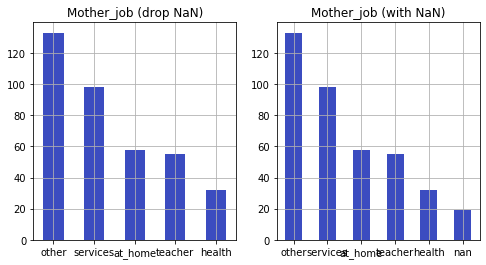

In [46]:
nominative_column_info(math.Mjob, column_name='Mother_job', rotation=0)

10. Колонка [Fjob] (номинативная переменная), содержит в себе признак места работы отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос. служба, 'at_home' - не работает, 'other' - другое). Отметим наличие пропусков в записях в количестве 36 или 9.1%. Из диаграммы распределния значений признака следует, что половина отцов 197 или 49.9% не указали конкретное место работы, 102 человека или 25.8% являются гос.служащими, 29 или 7.3% учителя, а 16 человек или 4.1% работают на дому. 15 человек или 3.8% работают в сфере здравоохранения. 

Признак Father_job:

Присутствуют пропущенные записи

with NaN:
          number  percent
other      197.0     49.9
services   102.0     25.8
NaN         36.0      9.1
teacher     29.0      7.3
at_home     16.0      4.1
health      15.0      3.8
Total:     395.0    100.0 

drop NaN:
          number  percent
other      197.0     54.9
services   102.0     28.4
teacher     29.0      8.1
at_home     16.0      4.5
health      15.0      4.2
Total:     359.0    100.1 



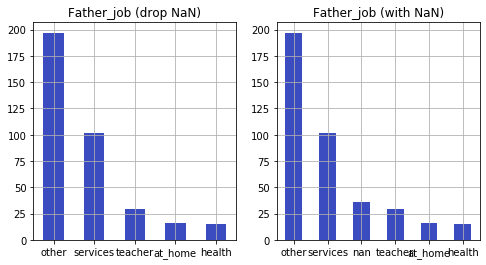

In [47]:
nominative_column_info(math.Fjob, column_name='Father_job', rotation=0)

11. Колонка [reason] (номинативная переменная), содержит в себе признак выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое). Содержит пропуски в количестве 17 или 4.3%. Из диаграммы следует, что большинство 137 или 34.7% выбирали учебное заведение, полагаясь на образовательную программу. Примерно одинаковое количество (104 и 103 или 26.3% и 26.1%) выбрали школу по близости к дому и репутации. Остальные 34 или 8.6% указали иные причины. 

Признак Reason:

Присутствуют пропущенные записи

with NaN:
            number  percent
course       137.0     34.7
home         104.0     26.3
reputation   103.0     26.1
other         34.0      8.6
NaN           17.0      4.3
Total:       395.0    100.0 

drop NaN:
            number  percent
course       137.0     36.2
home         104.0     27.5
reputation   103.0     27.2
other         34.0      9.0
Total:       378.0     99.9 



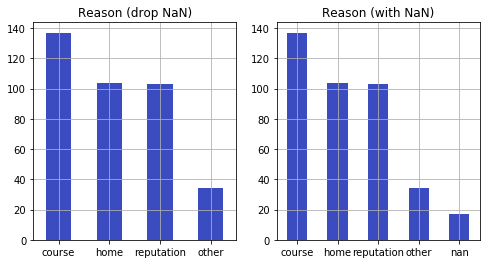

In [48]:
 nominative_column_info(math.reason, column_name='Reason', rotation=0)

12. Колонка [guardian] (номинативная переменная), содержит в себе признак опекуна ('mother' - мать, 'father' - отец, 'other' - другое). В столбце содержится 31 или 7.8% пропущенных записей. Из диаграммы следует, что подавляющее большинство опекунов - матери (250 ил 63.3%). Отцы в роли опекунов выступают в 86 или 21.8% случаев. 28 или 7.1% записей содержит признак другое.  

Признак Guardian:

Присутствуют пропущенные записи

with NaN:
        number  percent
mother   250.0     63.3
father    86.0     21.8
NaN       31.0      7.8
other     28.0      7.1
Total:   395.0    100.0 

drop NaN:
        number  percent
mother   250.0     68.7
father    86.0     23.6
other     28.0      7.7
Total:   364.0    100.0 



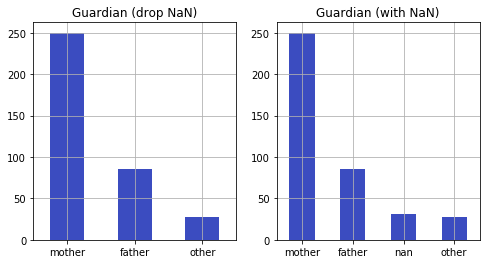

In [49]:
nominative_column_info(math.guardian, column_name='Guardian', rotation=0)

Признак Travel_time:

Присутствуют пропущенные записи

with NaN:
        number  percent
1.0      242.0     61.3
2.0       96.0     24.3
NaN       28.0      7.1
3.0       22.0      5.6
4.0        7.0      1.8
Total:   395.0    100.1 

drop NaN:
        number  percent
1.0      242.0     65.9
2.0       96.0     26.2
3.0       22.0      6.0
4.0        7.0      1.9
Total:   367.0    100.0 



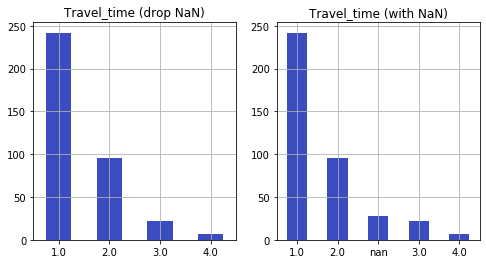

In [51]:
nominative_column_info(math.traveltime, column_name='Travel_time', rotation=0)

14. Колонка [studytime] (ранговая переменная), содержит в себе признак времени на учёбу помимо школы в неделю (1 - менее 2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - более 10 часов). В столбце присутствуют пропущенные записи в количестве 7 или 1.8%. Выбросов по указанным в описании границам не обнаружено. Из диаграммы следует, что почти половина учеников тратит на учебу дополнительно от 2 до 5 часов в неделю, примерно четверть - менее 2 часов. 16% учеников выделяют от 5 до 10 дополнительных часов, и только 6.8% - более 10 часов в неделю. 

Признак Study_time:

Присутствуют пропущенные записи

with NaN:
        number  percent
2.0      194.0     49.1
1.0      103.0     26.1
3.0       64.0     16.2
4.0       27.0      6.8
NaN        7.0      1.8
Total:   395.0    100.0 

drop NaN:
        number  percent
2.0      194.0     50.0
1.0      103.0     26.5
3.0       64.0     16.5
4.0       27.0      7.0
Total:   388.0    100.0 



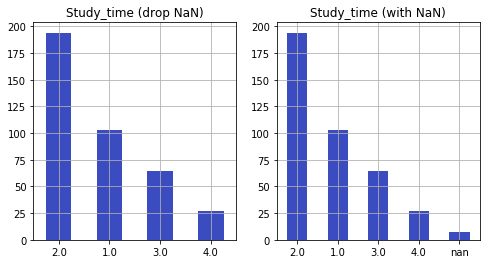

In [52]:
nominative_column_info(math.studytime, column_name='Study_time', rotation=0)

15. Колонка [failures] (ранговая переменная), содержит в себе признак внеучебных неудач (n, если n от 1 до 2, иначе 4). Столбец содержит 22 пропущенных значения. Интересно, что сразу обнаруживается большое количество выбросов (293), если задать в качестве границ значения описание признака (1-4). Очевидно, что ошибка закралась в описание, так как количество неудач может быть равно и 0, и 3. 

Признак Failures:

Всего записей: 373
Пропущенных (null): 22
Максимум: 3.0
75-й перцентиль: 0.0
50-й перцентиль: 0.0
25-й перцентиль: 0.0
Минимум: 0.0
Среднее арифм.: 0.3
СКО: 0.74
IQR: 0.0
Границы валидных данных: [1,4]
Обнаружены выбросы по Bounds
Выбросов: 293
Сверху: 0
Снизу: 293


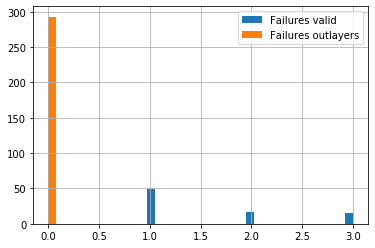

In [53]:
numeric_column_info(math.failures, column_name='Failures', bounds=(1,4))

Исправим описание, сказав, что в данном столбце описан признак внеучебных неудач (n если n = 0,1,2, иначе (при большем количестве) - 3). Тогда выбросов не будет и из диаграммы распределения будет следовать, что 74.2% учеников не испытывали внеучебных неудач. Одну неудачу испытали на себе 12.4% учеников, 2 неудачи - 4.1% и большее количество неудач - 3.8% учеников. 

Признак Failures:

Всего записей: 373
Пропущенных (null): 22
Максимум: 3.0
75-й перцентиль: 0.0
50-й перцентиль: 0.0
25-й перцентиль: 0.0
Минимум: 0.0
Среднее арифм.: 0.3
СКО: 0.74
IQR: 0.0
Границы валидных данных: [0,3]
Выбросов по Bounds не обнаружено


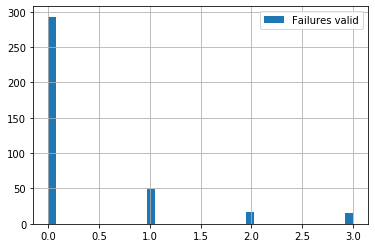

In [54]:
numeric_column_info(math.failures, column_name='Failures', bounds=(0,3))

Признак Failures:

Присутствуют пропущенные записи

with NaN:
        number  percent
0.0      293.0     74.2
1.0       49.0     12.4
NaN       22.0      5.6
2.0       16.0      4.1
3.0       15.0      3.8
Total:   395.0    100.1 

drop NaN:
        number  percent
0.0      293.0     78.6
1.0       49.0     13.1
2.0       16.0      4.3
3.0       15.0      4.0
Total:   373.0    100.0 



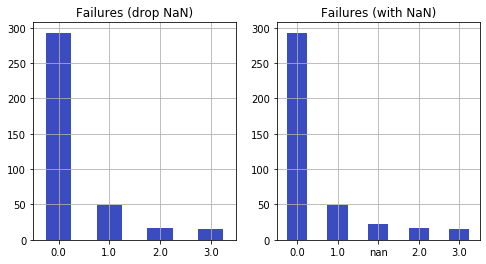

In [28]:
nominative_column_info(math.failures, column_name='Failures', rotation=0)

16. Колонка [schoolsup] (номинативная переменная), содержит в себе признак дополнительной образовательной поддержки (yes или no). Колонка содержит 9 или 2.3% пропущенных записей. Из диаграммы распределения следует, что большинство учеников 84.8% получают поддержку. И только 12.9% поддержки не получают. 

Признак School_support:

Присутствуют пропущенные записи

with NaN:
        number  percent
no       335.0     84.8
yes       51.0     12.9
NaN        9.0      2.3
Total:   395.0    100.0 

drop NaN:
        number  percent
no       335.0     86.8
yes       51.0     13.2
Total:   386.0    100.0 



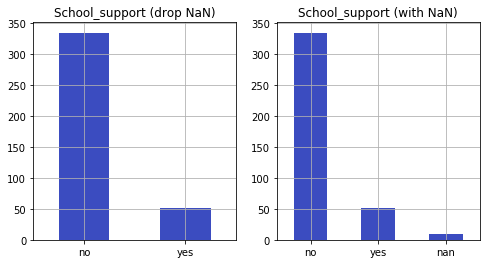

In [55]:
nominative_column_info(math.schoolsup, column_name='School_support', rotation=0)

17. Колонка [famsup] (номинативная переменная), содержит в себе признак семейной образовательной поддержки (yes или no).  Колонка содержит 39 или 9.9% пропущенных записей. Из диаграммы распределения следует, что более половины учеников 55.4% получает образовательную поддержку от семьи. 34.7% учеников обучаются без образовательной поддержки семьи. 

Признак Family_support:

Присутствуют пропущенные записи

with NaN:
        number  percent
yes      219.0     55.4
no       137.0     34.7
NaN       39.0      9.9
Total:   395.0    100.0 

drop NaN:
        number  percent
yes      219.0     61.5
no       137.0     38.5
Total:   356.0    100.0 



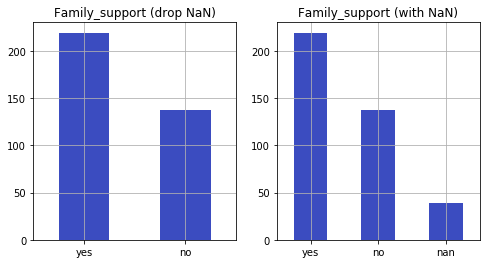

In [56]:
nominative_column_info(math.famsup, column_name='Family_support', rotation=0)

18. Колонка [paid] (номинативная переменная), содержит в себе признак дополнительных платных занятий по математике (yes или no). Столбец содержит 40 пропущенных записей. Из диаграммы распределния следует, что 50.6% учеников не прибегают к платным занятиям по математике, в то время как 39.2% учеников занимаются математикой за дополнительную плату.

Признак Paid:

Присутствуют пропущенные записи

with NaN:
        number  percent
no       200.0     50.6
yes      155.0     39.2
NaN       40.0     10.1
Total:   395.0     99.9 

drop NaN:
        number  percent
no       200.0     56.3
yes      155.0     43.7
Total:   355.0    100.0 



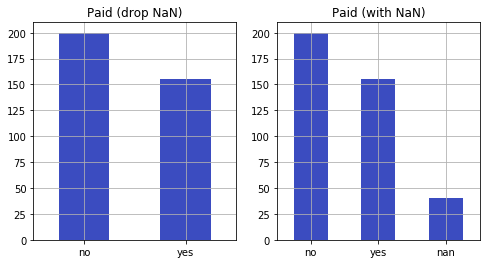

In [57]:
nominative_column_info(math.paid, column_name='Paid', rotation=0)

19. Колонка [activities] (номинативная переменная), содержит в себе признак дополнительных внеучебных занятий (yes или no). Колонка содержит 14 пропущенных записей. Из диаграммы следует, что количество учеников прибегающих к дополнительным внеучебным занятиям примерно равно количеству учеников, не посещающих дополнительные занятия.  

Признак Activities:

Присутствуют пропущенные записи

with NaN:
        number  percent
yes      195.0     49.4
no       186.0     47.1
NaN       14.0      3.5
Total:   395.0    100.0 

drop NaN:
        number  percent
yes      195.0     51.2
no       186.0     48.8
Total:   381.0    100.0 



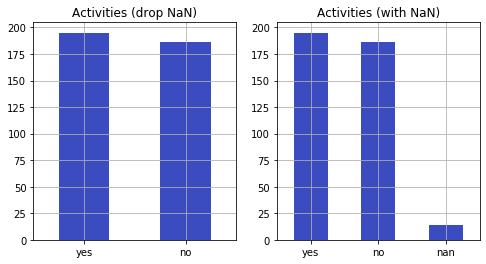

In [58]:
nominative_column_info(math.activities, column_name='Activities', rotation=0)

20. Колонка [nursery] (номинативная переменная), содержит в себе признак посещения детского сада (yes или no). В колонке присутствует 16 пропущенных записей. Диаграмма распределения показывает, что большинство (75.9%) учеников посещали детский сад, в то время как остальные 20% не посещали.  

Признак Nursery:

Присутствуют пропущенные записи

with NaN:
        number  percent
yes      300.0     75.9
no        79.0     20.0
NaN       16.0      4.1
Total:   395.0    100.0 

drop NaN:
        number  percent
yes      300.0     79.2
no        79.0     20.8
Total:   379.0    100.0 



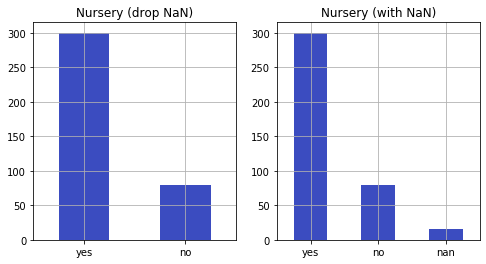

In [59]:
nominative_column_info(math.nursery, column_name='Nursery', rotation=0)

21. Колонка [higher] (номинативная переменная), содержит в себе признак желания получить высшее образование (yes или no). В колонке присутствует 19 пропущенных записей. Диаграмма распределения показывает, что большинство (90.1%) учеников хотят получить высшее образование, и лишь 4.8% не хотят.  

Признак Higher_education:

Присутствуют пропущенные записи

with NaN:
        number  percent
yes      356.0     90.1
NaN       20.0      5.1
no        19.0      4.8
Total:   395.0    100.0 

drop NaN:
        number  percent
yes      356.0     94.9
no        19.0      5.1
Total:   375.0    100.0 



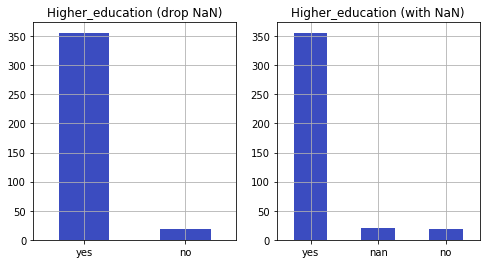

In [60]:
nominative_column_info(math.higher, column_name='Higher_education', rotation=0)

22. Колонка [internet] (номинативная переменная), содержит в себе признак наличия интернета дома (yes или no). В колонке присутствует 34 пропущенные записи. Диаграмма распределения показывает, что большинство (77.2%) учеников имеют доступ к интернету из дома, в то время как 14.2% не имеют доступа.  

Признак Internet:

Присутствуют пропущенные записи

with NaN:
        number  percent
yes      305.0     77.2
no        56.0     14.2
NaN       34.0      8.6
Total:   395.0    100.0 

drop NaN:
        number  percent
yes      305.0     84.5
no        56.0     15.5
Total:   361.0    100.0 



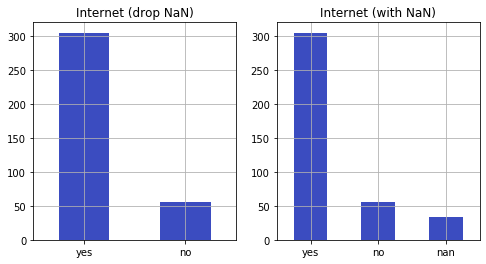

In [61]:
 nominative_column_info(math.internet, column_name='Internet', rotation=0)

23. Колонка [romantic] (номинативная переменная), содержит в себе признак наличия романтических отношений (yes или no). В колонке присутствует 31 пропущенная запись. Диаграмма распределения показывает, что большинство (60.8%) учеников не имеют романтических отношений, в то время как 31.4% состоят в таковых.  

Признак Romantic:

Присутствуют пропущенные записи

with NaN:
        number  percent
no       240.0     60.8
yes      124.0     31.4
NaN       31.0      7.8
Total:   395.0    100.0 

drop NaN:
        number  percent
no       240.0     65.9
yes      124.0     34.1
Total:   364.0    100.0 



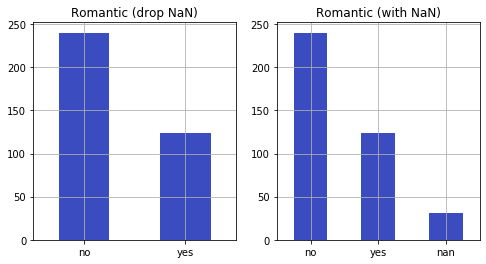

In [62]:
nominative_column_info(math.romantic, column_name='Romantic', rotation=0)

24. Колонка [famrel] (ранговая переменная), содержит в себе признак семейных отношений (от 1 - очень плохо до 5 - очень хорошо). Во-первых, мы видим 27 пропущенных записей и один выброс за границы указанного диапазона. 

Признак Family_relationships:

Присутствуют пропущенные записи

with NaN:
        number  percent
4.0      182.0     46.1
5.0       99.0     25.1
3.0       62.0     15.7
NaN       27.0      6.8
2.0       17.0      4.3
1.0        7.0      1.8
-1.0       1.0      0.3
Total:   395.0    100.1 

drop NaN:
        number  percent
4.0      182.0     49.5
5.0       99.0     26.9
3.0       62.0     16.8
2.0       17.0      4.6
1.0        7.0      1.9
-1.0       1.0      0.3
Total:   368.0    100.0 



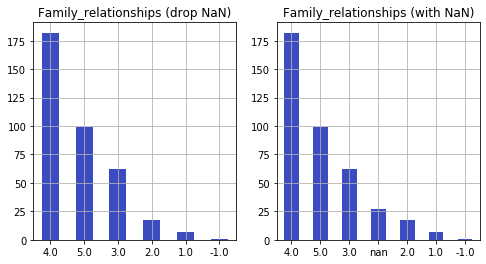

In [63]:
nominative_column_info(math.famrel, column_name='Family_relationships', rotation=0)

Найдем выброс:

In [64]:
math[math.famrel<1]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
25,GP,F,16,U,GT3,NaN,2.0,2.0,services,services,...,no,yes,yes,no,-1.0,2.0,2.0,5.0,14.0,40.0


Скорее всего, была допущена ошибка в знаке, уберем знак минус, записав признак 1

In [66]:
math.loc[25, 'famrel'] = 1

После преобразования имеем отсутствие выбросов. Диаграмма показывает, что большинство учеников находятся в хороших или отличных отношениях с семьей (71.2%), 15.7% находятся в удовлетворительных, а 6.3% - в плохих  отношениях с семьей. 

Признак Family_relationships:

Присутствуют пропущенные записи

with NaN:
        number  percent
4.0      182.0     46.1
5.0       99.0     25.1
3.0       62.0     15.7
NaN       27.0      6.8
2.0       17.0      4.3
1.0        8.0      2.0
Total:   395.0    100.0 

drop NaN:
        number  percent
4.0      182.0     49.5
5.0       99.0     26.9
3.0       62.0     16.8
2.0       17.0      4.6
1.0        8.0      2.2
Total:   368.0    100.0 



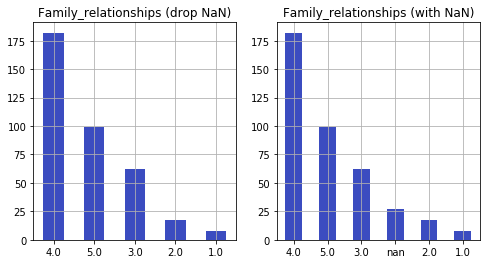

In [67]:
nominative_column_info(math.famrel, column_name='Family_relationships', rotation=0)

25. Колонка [freetime] (ранговая переменная), содержит в себе признак наличия свободного времени после школы (от 1 - очень мало до 5 - очень много). Отметим 11 пропущенных записей в столбце. Выбросов не обнаружено. Признак распределен нормально.

Признак Free_time:

Всего записей: 384
Пропущенных (null): 11
Максимум: 5.0
75-й перцентиль: 4.0
50-й перцентиль: 3.0
25-й перцентиль: 3.0
Минимум: 1.0
Среднее арифм.: 3.2
СКО: 0.99
IQR: 1.0
Границы валидных данных: [1,5]
Выбросов по Bounds не обнаружено


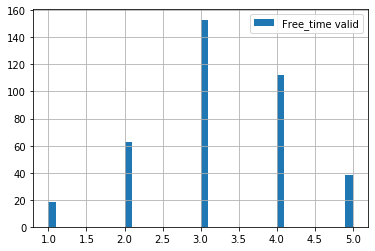

In [68]:
numeric_column_info(math.freetime, column_name='Free_time', bounds=(1,5))

Признак Free_time:

Присутствуют пропущенные записи

with NaN:
        number  percent
3.0      153.0     38.7
4.0      112.0     28.4
2.0       63.0     15.9
5.0       38.0      9.6
1.0       18.0      4.6
NaN       11.0      2.8
Total:   395.0    100.0 

drop NaN:
        number  percent
3.0      153.0     39.8
4.0      112.0     29.2
2.0       63.0     16.4
5.0       38.0      9.9
1.0       18.0      4.7
Total:   384.0    100.0 



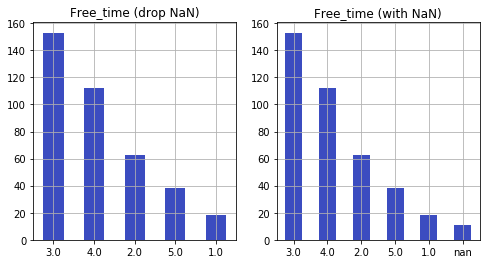

In [69]:
nominative_column_info(math.freetime, column_name='Free_time', rotation=0)

26. Колонка [goout] (ранговая переменная), содержит в себе признак наличия времени с друзьями (от 1 - очень мало до 5 - очень много). Отметим 8 пропущенных записей в столбце. Выбросов не обнаружено.  Признак распределен нормально.

Признак Go_out:

Всего записей: 387
Пропущенных (null): 8
Максимум: 5.0
75-й перцентиль: 4.0
50-й перцентиль: 3.0
25-й перцентиль: 2.0
Минимум: 1.0
Среднее арифм.: 3.1
СКО: 1.12
IQR: 2.0
Границы валидных данных: [1,5]
Выбросов по Bounds не обнаружено


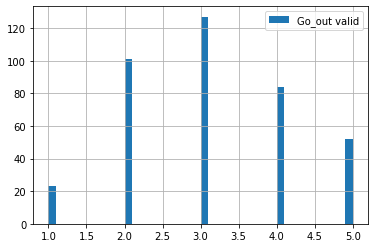

In [70]:
numeric_column_info(math.goout, column_name='Go_out', bounds=(1,5))

27. Колонка [health] (ранговая переменная), содержит в себе признак текущего состояния здоровья (от 1 - очень плохо до 5 - очень хорошо). Отметим 15 пропущенных записей в столбце. Диаграмма говорит о том, что 50% учеников обладают отличным или хорошим здоровьем, в то время как оставшаяся половина испытывает проблемы со здоровьем.

Признак Health:

Присутствуют пропущенные записи

with NaN:
        number  percent
5.0      138.0     34.9
3.0       89.0     22.5
4.0       63.0     15.9
1.0       47.0     11.9
2.0       43.0     10.9
NaN       15.0      3.8
Total:   395.0     99.9 

drop NaN:
        number  percent
5.0      138.0     36.3
3.0       89.0     23.4
4.0       63.0     16.6
1.0       47.0     12.4
2.0       43.0     11.3
Total:   380.0    100.0 



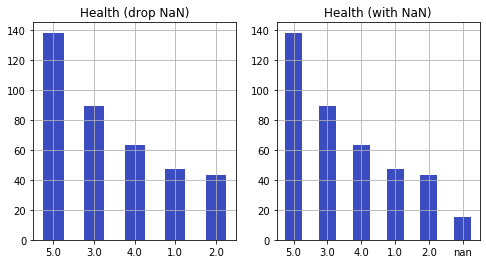

In [71]:
nominative_column_info(math.health, column_name='Health', rotation=0)

28. Колонка [absences] (количественная переменная), содержит в себе признак количества пропущенных занятий. Отметим 12 пропущенных записей в столбце. Сразу же обнаруживаем 17 выбросов по IQR.

Признак Absences:

Всего записей: 383
Пропущенных (null): 12
Максимум: 385.0
75-й перцентиль: 8.0
50-й перцентиль: 4.0
25-й перцентиль: 0.0
Минимум: 0.0
Среднее арифм.: 7.3
СКО: 23.47
IQR: 8.0
Границы валидных данных: [-12.0,20.0]
Обнаружены выбросы по IQR
Выбросов: 17
Сверху: 17
Снизу: 0


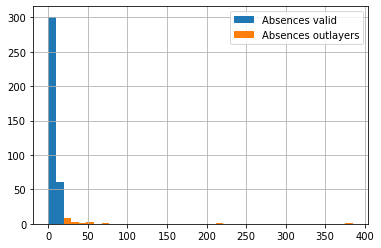

In [72]:
numeric_column_info(math.absences, column_name='Absences')

Посмотрим на выбросы по IQR:

In [73]:
math[math.absences>20]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
40,GP,F,16,U,LE3,T,2.0,2.0,other,other,...,no,yes,yes,yes,3.0,3.0,3.0,3.0,25.0,55.0
74,GP,F,16,U,GT3,T,3.0,3.0,other,services,...,yes,yes,yes,no,4.0,NaN,3.0,5.0,54.0,55.0
103,GP,F,15,U,GT3,T,3.0,2.0,services,other,...,yes,yes,yes,no,4.0,3.0,5.0,2.0,26.0,30.0
183,GP,F,17,U,LE3,NaN,3.0,3.0,other,other,...,yes,yes,yes,yes,5.0,3.0,3.0,1.0,56.0,40.0
198,GP,F,17,U,GT3,NaN,4.0,4.0,services,teacher,...,yes,yes,NaN,no,4.0,2.0,4.0,2.0,24.0,90.0
205,GP,F,17,U,GT3,T,3.0,4.0,at_home,services,...,yes,yes,yes,yes,4.0,4.0,3.0,5.0,28.0,45.0
216,GP,F,17,U,GT3,T,4.0,3.0,other,NaN,...,yes,yes,yes,yes,3.0,4.0,5.0,1.0,22.0,20.0
222,GP,F,16,U,GT3,T,2.0,3.0,services,teacher,...,yes,yes,yes,no,2.0,3.0,1.0,3.0,385.0,85.0
260,GP,F,18,U,GT3,NaN,4.0,3.0,NaN,other,...,yes,yes,yes,yes,3.0,1.0,2.0,2.0,21.0,90.0
276,GP,F,18,R,GT3,A,3.0,2.0,other,services,...,no,no,yes,yes,NaN,1.0,1.0,5.0,75.0,45.0


Здравый смысл говорит о том, что количество пропущенных занятий может быть сколь угодно большим, вплоть до пропуска абсолютно всех занятий (по болезни, например). Среди всех выбросов выделяются два (385 и 212). Понятно, что здесь произошло что-то аномальное. Уберем эти записи, оставив пропущенные. 

In [74]:
math1=math[math.absences.isnull()]
math2=math[math.absences<=100]
math=pd.concat([math1, math2])

Признак Absences:

Всего записей: 381
Пропущенных (null): 12
Максимум: 75.0
75-й перцентиль: 8.0
50-й перцентиль: 4.0
25-й перцентиль: 0.0
Минимум: 0.0
Среднее арифм.: 5.8
СКО: 8.09
IQR: 8.0
Границы валидных данных: [-12.0,20.0]
Обнаружены выбросы по IQR
Выбросов: 15
Сверху: 15
Снизу: 0


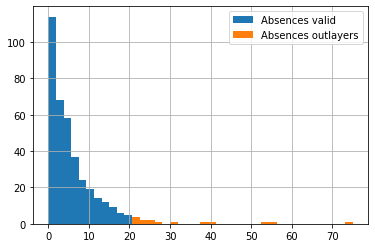

In [75]:
# После отбраковки выбросов по IQR
numeric_column_info(math.absences, column_name='Absences')

Несмотря на наличие выбросов по IQR, не будем больше удалять данные, исходя из здравого смысла. Теперь в датасете осталось 393 записи. 

29. Колонка [score] (количественная переменная), содержит в себе признак количества баллов по математике. Столбец содержит 6 пропущенных записей. Диаграмма показывает нам нормальное распределение оценок со средним 52.2 и ско 22.9. Хорошо виден "выброс" в левой части, состоящий из 37 записей с оценкой 0. Нет никаких причин удалять эти записи, так как они не являются выбросами ни по IQR, ни по границам возможных значений параметра. 

Признак Score:

Всего записей: 387
Пропущенных (null): 6
Максимум: 100.0
75-й перцентиль: 70.0
50-й перцентиль: 55.0
25-й перцентиль: 40.0
Минимум: 0.0
Среднее арифм.: 52.2
СКО: 22.91
IQR: 30.0
Границы валидных данных: [0,100]
Выбросов по Bounds не обнаружено


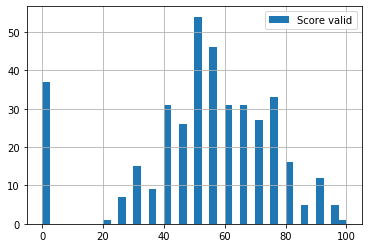

In [76]:
numeric_column_info(math.score, column_name='Score', bounds=(0,100))

In [77]:
len(math[math.score==0])

37

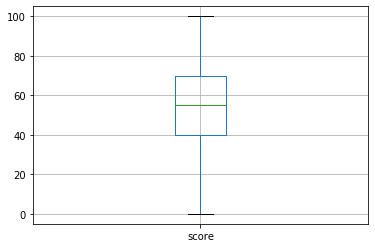

In [78]:
boxplot = math.boxplot(column=['score'])

В данных присутствуют пропущенные значения, о распределении которых говорит диаграмма. Из неё следует, что максимальное количество пропущенных данных в столбцах не превосходит 12%. Максимальное количество пропусков в столбце [Pstatus] (около 12%). Три столбца [school], [sex] и [age] не содержат пропусков. Существует много вариантов восстановления значений, но пока мне непонятно как это использовать и, что самое главное, как это  повлияет на модель в дальнейшем. Поэтому просто удалим все записи с пропущенными значениями.

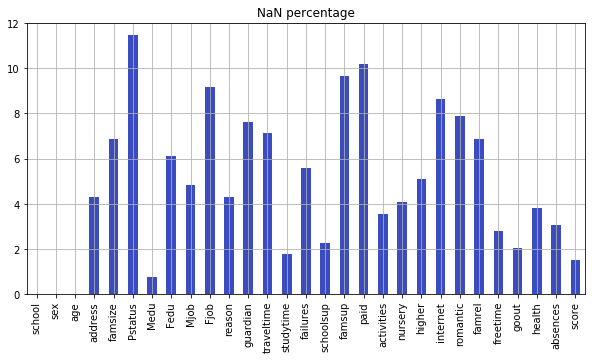

In [79]:
(math.isnull().sum()*100/math.shape[0]).plot(figsize=(10,5),kind='bar',grid=True,colormap='coolwarm',title='NaN percentage')

In [80]:
math=math.dropna()
math.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97 entries, 4 to 391
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      97 non-null     object 
 1   sex         97 non-null     object 
 2   age         97 non-null     int64  
 3   address     97 non-null     object 
 4   famsize     97 non-null     object 
 5   Pstatus     97 non-null     object 
 6   Medu        97 non-null     float64
 7   Fedu        97 non-null     float64
 8   Mjob        97 non-null     object 
 9   Fjob        97 non-null     object 
 10  reason      97 non-null     object 
 11  guardian    97 non-null     object 
 12  traveltime  97 non-null     float64
 13  studytime   97 non-null     float64
 14  failures    97 non-null     float64
 15  schoolsup   97 non-null     object 
 16  famsup      97 non-null     object 
 17  paid        97 non-null     object 
 18  activities  97 non-null     object 
 19  nursery     97 non-null     ob

 После такой фильтрации останется 97 записей.

### Выводы по первичной обработке данных

Итак, проведенная первичная обработка показала, что датасет содержит 29 переменных, из них три - количественные ([age], [absences] и [score]), 9 - ранговых и 17 номинативных.  Данные довольно чистые, так как изменения внесены лишь в очень небольшое количество записей: [fedu] - лишний ноль в 1 записи, [famrel] - ошибочный знак минус, [absences] - два аномальных выброса, [failures] - подправлено описание, удалён 1 столбец [studytime, granular] так как отсутствует его описание, кроме того, он повторяет [studytime] с коэффициентом (-3).

## 2. Корреляционный анализ количественных переменных

Вычислим матрицу корреляции для количественных и ранговых переменных и построим её heatmap для лучшего представления:

In [81]:
corr_matrix = math.corr()
corr_matrix

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
age,1.000000,-0.071662,-0.056929,0.143682,-0.220209,0.320914,0.057039,0.040115,0.106748,0.037152,0.142780,-0.186407
Medu,-0.071662,1.000000,0.684379,-0.248099,-0.042491,-0.135065,-0.032146,-0.032350,0.023938,-0.124250,0.101253,0.064914
Fedu,-0.056929,0.684379,1.000000,-0.162149,-0.001350,-0.189926,-0.059084,-0.135575,-0.087894,0.086575,0.059172,-0.014236
traveltime,0.143682,-0.248099,-0.162149,1.000000,-0.034571,-0.029138,-0.134113,-0.071376,-0.094331,0.147160,-0.148719,-0.094874
studytime,-0.220209,-0.042491,-0.001350,-0.034571,1.000000,-0.016541,0.025253,-0.226503,-0.129162,-0.067115,-0.018695,-0.029742
failures,0.320914,-0.135065,-0.189926,-0.029138,-0.016541,1.000000,-0.095520,-0.043110,-0.021022,0.057279,0.239602,-0.314698
famrel,0.057039,-0.032146,-0.059084,-0.134113,0.025253,-0.095520,1.000000,0.084336,0.069922,0.178145,0.016312,-0.026742
freetime,0.040115,-0.032350,-0.135575,-0.071376,-0.226503,-0.043110,0.084336,1.000000,0.381049,0.120714,0.093512,0.068862
goout,0.106748,0.023938,-0.087894,-0.094331,-0.129162,-0.021022,0.069922,0.381049,1.000000,-0.033206,0.094859,-0.079187
health,0.037152,-0.124250,0.086575,0.147160,-0.067115,0.057279,0.178145,0.120714,-0.033206,1.000000,-0.019866,-0.103462


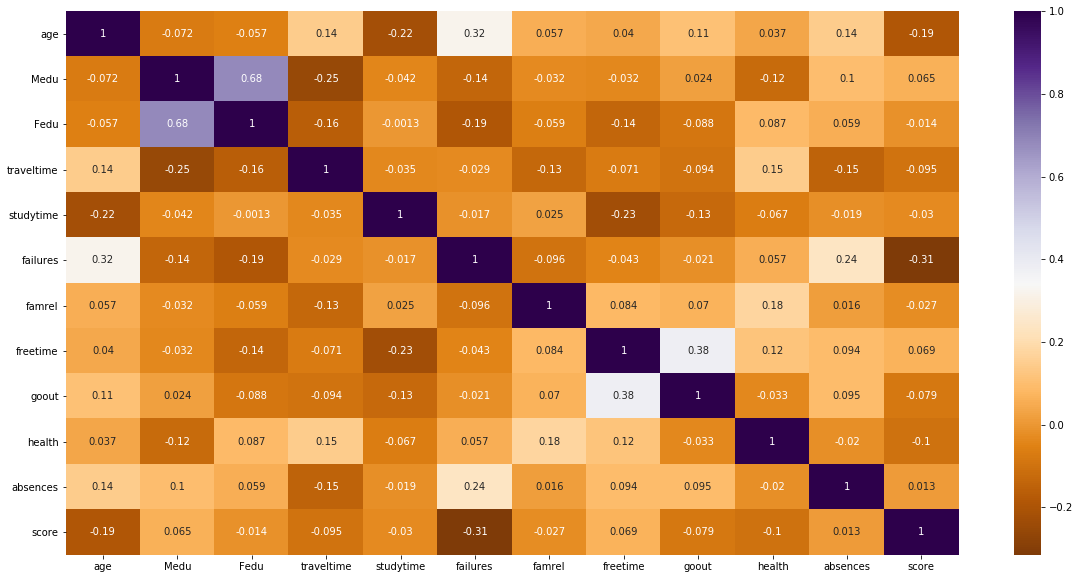

In [98]:
plt.figure(figsize=(20,10))
#sns.heatmap(corr_matrix,annot=True,square=True)
sns.heatmap(corr_matrix, cmap="PuOr", annot=True)

### Выводы по корреляционному анализу 

Стоит отметить, что признаки **Fedu** (образование отца) и **Medu** (образование матери) хорошо скореллированы (умеренная корреляция). Также хорошо скореллироваными (нижняя граница умеренной корреляции) являются **goout** - время, проводимое с друзьями и **freetime** - свободное время после школы. Отметим, что сам по себе коэффициент корреляции может отображать наличие только линейной связи между переменными, его близость к 1 или -1 еще не говорит о зависимости признаков. А вот его близость к 0 может говорить об отсутствии линейной связи между переменными. Так что, возможно, **Fedu** и **Medu**, а также **goout** и **freetime** зависимы, но подтверждение этого факта требует дополнительной проверки. Так как в рекомендациях по выполнению проекта сказано отобрать некоррелирующие данные, то уберем из дальнейшего рассмотрения столбец **Fedu**, оставив при этом **Medu**.

Интересно отметить возможную обратную зависимость возраста **age** и оценки **score**. Также заметна возможная положительная связь между временем на учёбу помимо школы **studytime** и оценкой. Обратная зависимость с оценкой наблюдается с количеством внеучебных неудач **failures**, а также временем, проводимым с друзьями **goout**.

## 3. Анализ номинативных переменных

Как уже было сказано выше, в нашем наборе данных 17 номинативных переменных, отберем их: 

In [99]:
all_variables = list(math.columns)
index = [0, 1, 3, 4, 5, 8, 9, 10, 11, 15, 16, 17, 18, 19, 20, 21, 22]
nominative_variables = []
for k in index:
    nominative_variables.append(all_variables[k])

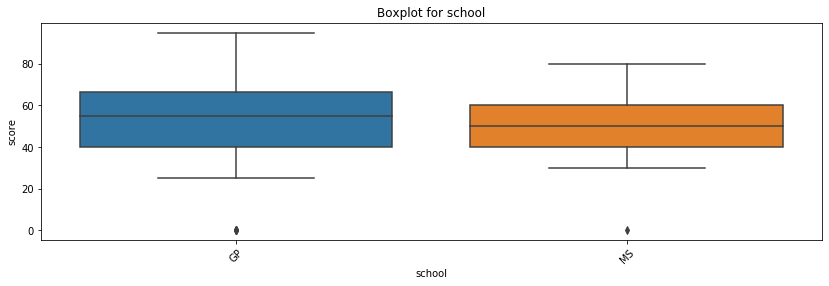

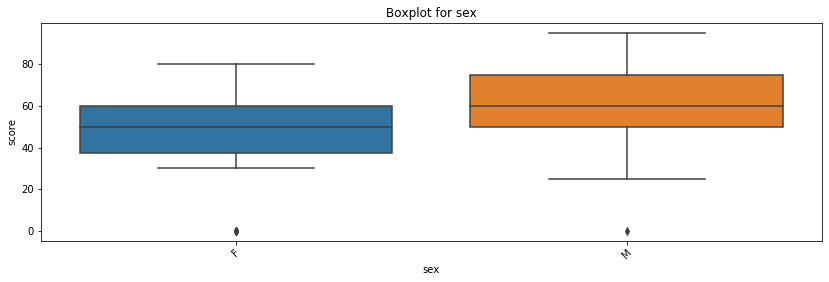

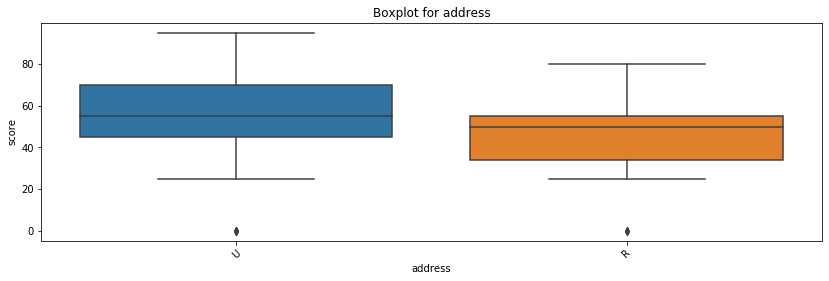

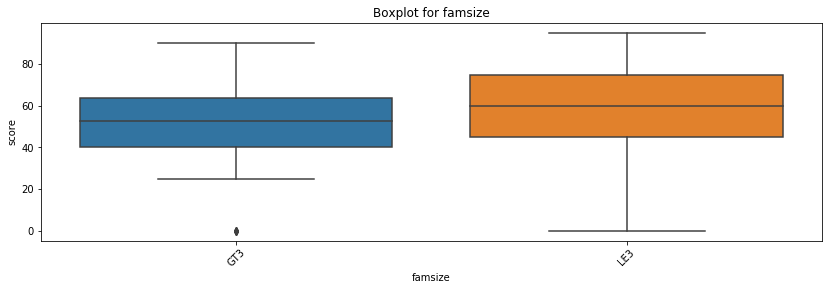

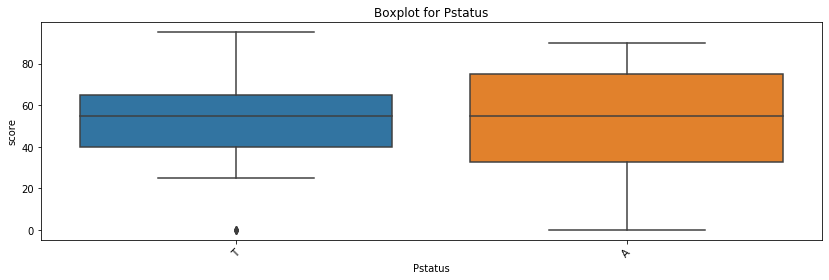

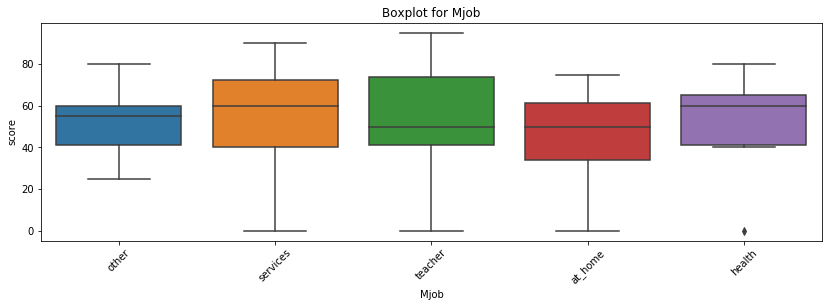

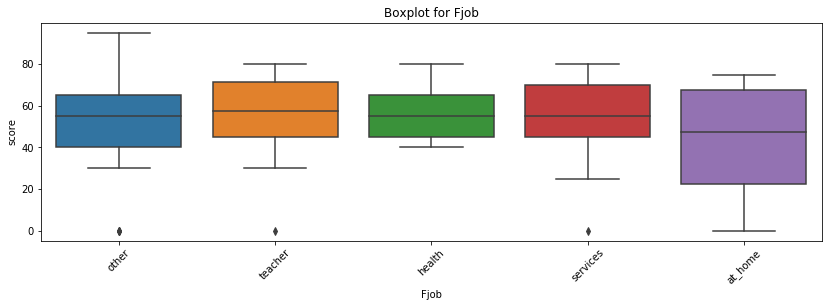

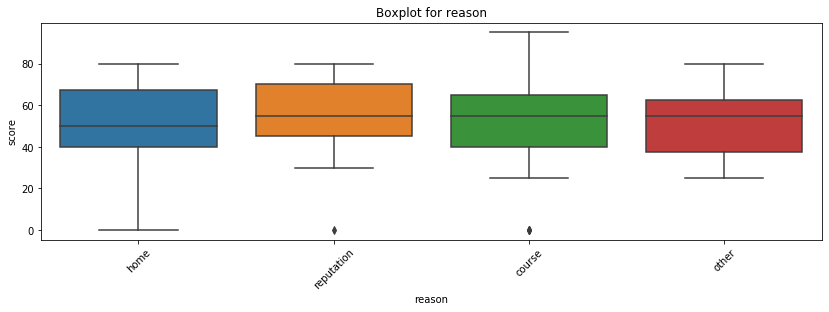

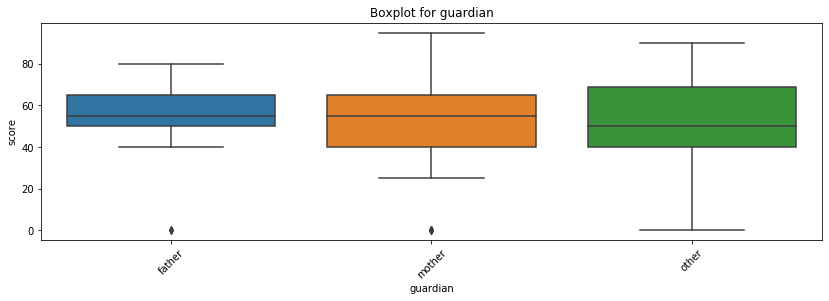

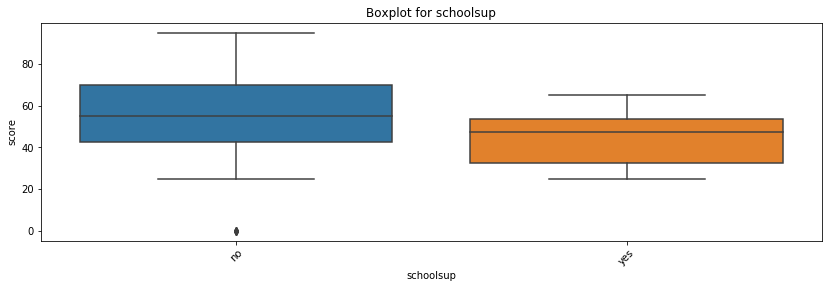

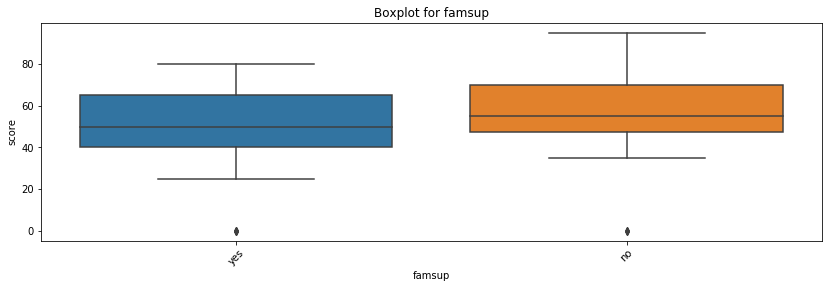

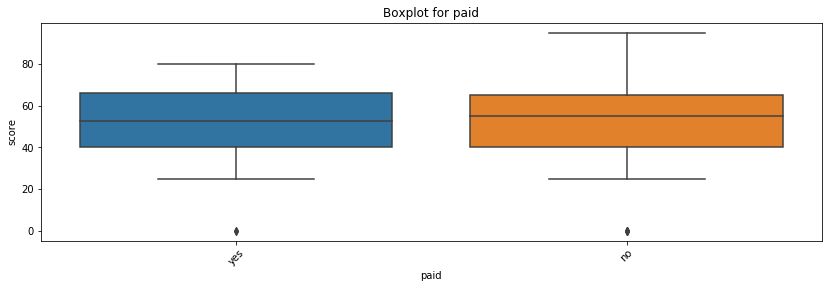

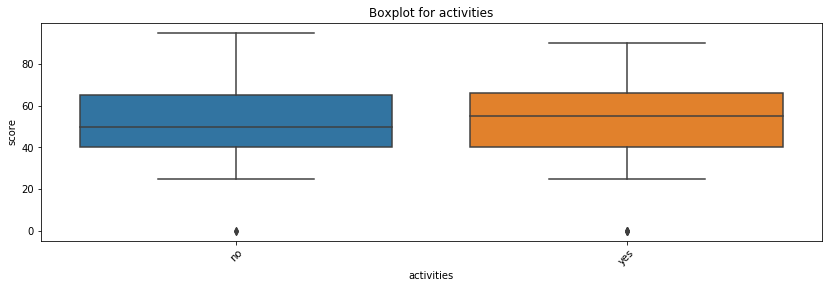

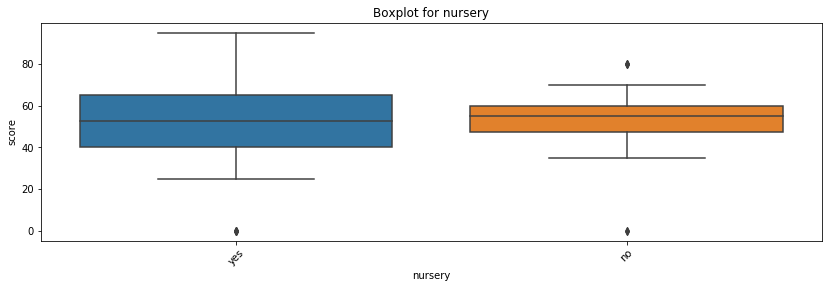

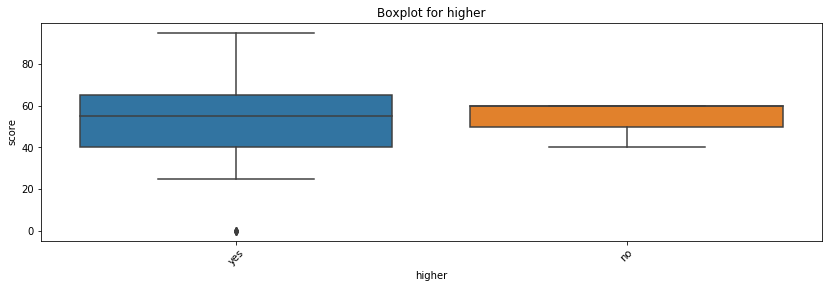

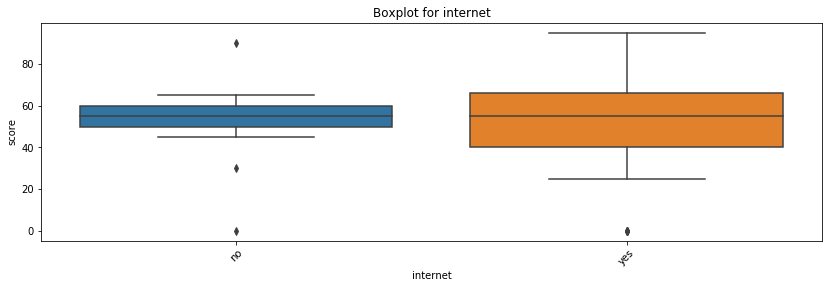

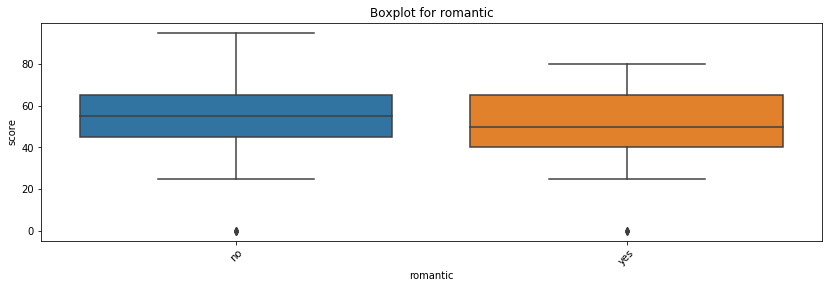

In [100]:
def get_boxplot(df, column, goal_column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y=goal_column, 
                data=df.loc[math.loc[:, column].isin(df.loc[:, column].value_counts().index[:])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

for col in nominative_variables:
    get_boxplot(math, col, 'score')

In [101]:
def get_stat_dif(df, column, goal_column, alpha=0.05):
    cols = df.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], goal_column], 
                        df.loc[df.loc[:, column] == comb[1], goal_column],nan_policy='omit').pvalue \
            <= alpha/len(combinations_all): # Учли поправку Бонферони
            return True
            break
    return False

def stat_difference_analyse(df, columns, goal_column, alpha=0.05):   
    stat_dif=[]
    alpha = 0.05

    for col in nominative_variables:
        if get_stat_dif(df, col, 'score', alpha):
            stat_dif.append(col)

    if len(stat_dif):
        print('Найдены статистически значимые отличия в колонках:\n')
        print(stat_dif)
    else: 
        print('Cтатистически значимые отличия в колонках не найдены!\n')

In [102]:
stat_difference_analyse(math, nominative_variables, 'score', alpha=0.05)

Найдены статистически значимые отличия в колонках:

['sex', 'address', 'famsize']


### Выводы по анализу номинативных переменных

Итак, в нашем случае важные номинативные переменные, которые, возможно, оказывают влияние на оценку **score**, это: **sex**, **address** и **famsize**, добавим к ним слабоскореллированные переменные из корреляционного анализа, а именно **age**, **Medu**, **traveltime**, **studytime**, **failures**, **famrel**, **freetime**, **goout**, **health**, **absences** и получим итогоый датасет для дальнейшего моделирования: 

In [103]:
math_for_model = math.loc[:, ['age','sex','address','famsize','Medu','traveltime','studytime',
                             'failures','famrel','freetime','goout','health','absences','score']]
math_for_model.head()

,age,sex,address,famsize,Medu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
4,16,F,U,GT3,3.0,1.0,2.0,0.0,4.0,3.0,2.0,5.0,4.0,50.0
5,16,M,U,LE3,4.0,1.0,2.0,0.0,5.0,4.0,2.0,5.0,10.0,75.0
7,17,F,U,GT3,4.0,2.0,2.0,0.0,4.0,1.0,4.0,1.0,6.0,30.0
10,15,F,U,GT3,4.0,1.0,2.0,0.0,3.0,3.0,3.0,2.0,0.0,45.0
14,15,M,U,GT3,2.0,1.0,3.0,0.0,4.0,5.0,2.0,3.0,0.0,80.0


## Основные итоги работы

При работе над данным проектом был выполнен первичный анализ данных, а именно: проанализированы все переменные, определен их тип, распределение, выявлен процент пропущенных записей. Также были скорректированы некоторые из переменных на основе анализа выбросов и здравого смысла. Пропущенные записи  были удалены из исходных данных. Сделан вывод о том, что данные являются чистыми, но содержат довольно большое количество пропусков. Выполненный корреляционный анализ ранговых и количественных переменных позволил отобрать только слабоскоррелированные переменные. Анализ номинативных переменных, основанный на тесте Стьюдента с проверкой нулевой гипотезы о том, что распределения оценок госэкзамена по различным параметрам неразличимы позволил отобрать лишь те переменные, которые являются статистически различимыми. 